# LIBS Analysis

In [3]:
# auto reload external packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# import dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from plotly.offline import iplot, init_notebook_mode
import plotly.tools as tls
import plotly.graph_objs as go

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns

init_notebook_mode(connected=True)

In [5]:
# raw_reading: single reading (corrupted or not, it is unknown)
# reading: subsampled or averaged multiple raw_readings - probably more noise free

# {BASEPATH}/{sample_path}/{raw_readings}.csv

# sample_path : one path of sample of soils (adana, samsun, etc.) - ex:{BASEPATH}/{labno}
# raw_reading_path : one path reading of one sample of soils (adana, samsun, etc.) - ex:{BASEPATH}/{labno}/{unix_rtime}.csv

BASEPATH = "samples"
LOCATION = "adana" # adana, samsun, nigde, yozgat

MAX_NM = 604.
MIN_NM = 247.8
NUM_DATAPOINTS = 4096


TICK_PERIOD = (MAX_NM-MIN_NM)/NUM_DATAPOINTS
SAMPLE_PATHS = list(Path(BASEPATH).glob('*'))

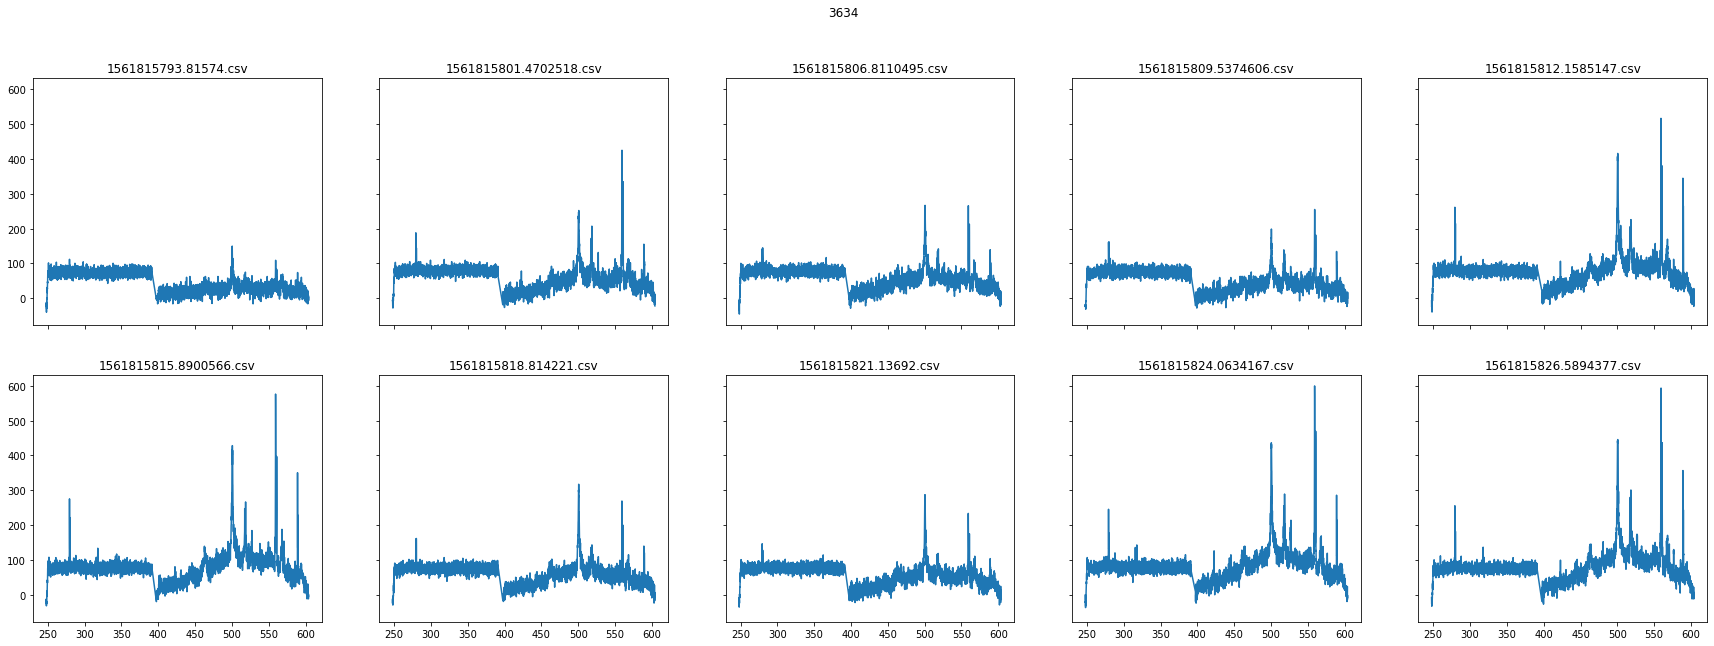

In [10]:
# create and save .png file for all readings per sample
def subplot25(sample_readings_paths):
    fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(30,10))
    for ix, sample_path in enumerate(sample_readings_paths):
        df = pd.read_csv(sample_path)
        ax = axes[ix//5,ix%5]
        ax.plot(df['wavelengths'], df['intensities'], )
        ax.set_title(sample_path.name)
    fig.suptitle(sample_path.parent.name)
    image_save_path = sample_path.parent
    plt.savefig(image_save_path / 'readings.png')
    
    
# Call it
for sample_path in SAMPLE_PATHS:
    raw_reading_paths = Path(sample_path).glob('*.csv') # filter csv files
    # show and save figures
    subplot25(raw_reading_paths)

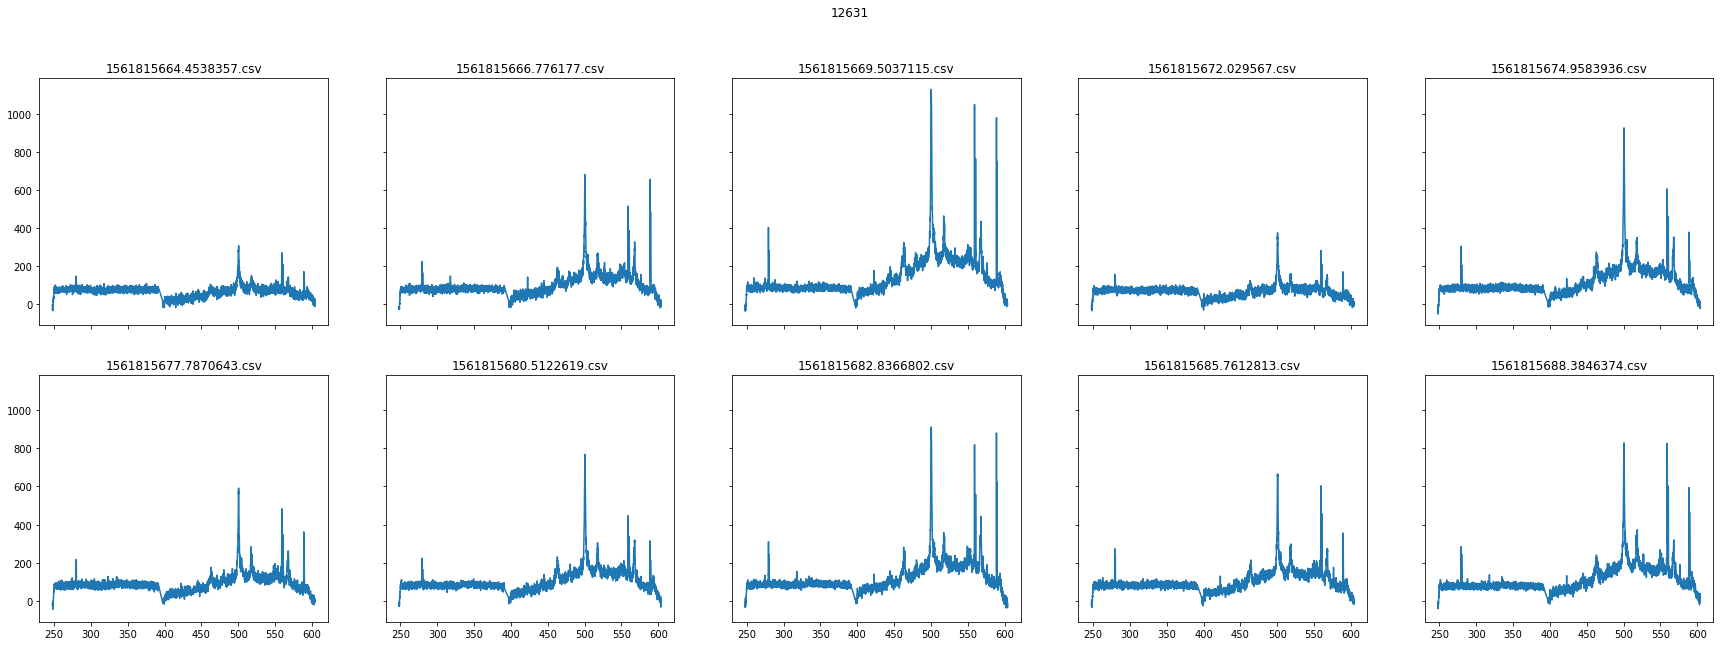

In [12]:
# 1 Sample of subplot25
raw_reading_paths = Path(SAMPLE_PATHS[0]).glob('*.csv')
subplot25(raw_reading_paths)

In [13]:
from functools import partial
from scipy import signal

class Sample:
    def __init__(self, sample_path):
        self.raw_readings = [pd.read_csv(raw_reading_path) 
                             for raw_reading_path in Path(sample_path).glob('*.csv')]
        
        # average samples
        self.reading = self.dataframes_average(self.raw_readings)
        # round sample
        self.reading = self.reading.round(3)
        self.plot = partial(self.subplot, [self.reading], 1, 1)
        
        self.reading = self.find_peaks(self.reading)
        self.sample_path = sample_path
        self.labno = int(sample_path.name)
    
    @staticmethod
    def find_peaks(reading, inplace=False):
        if not inplace:
            reading = reading.copy()
        
        peak_interval = 1.
        wavelengths = reading['wavelengths'].values
        intensities = reading['intensities'].values
        
        wavelengths_range = wavelengths.max() - wavelengths.min()
        sampling_interval = wavelengths_range / wavelengths.shape[0]

        peak_ixs = signal.argrelmax(intensities,
                                    order=int(peak_interval / sampling_interval))[0]
        
        reading['is_peak'] = False
        reading.loc[peak_ixs, 'is_peak'] = True
        return reading
    
    @staticmethod
    def get_reading_cond(intensities_above=200, is_peak=True):
        return s.reading.loc[(s.reading['intensities'] > intensities_above) & (s.reading['is_peak']==is_peak)]
        
        
    @staticmethod
    def subplot(readings, row, col):
        fig, axes = plt.subplots(row, col, sharex=True, sharey=True, squeeze=False)
        for ix, reading in enumerate(readings):
            axes[ix//col,ix%col if col!=1 else 0].plot(reading['wavelengths'], reading['intensities'])

    @staticmethod
    def plotly_plot(s):
        peak_df = s.reading.loc[s.reading['is_peak'] == True, :]
        trace_reading = go.Scatter(x=s.reading['wavelengths'], y=s.reading['intensities'], name='reading')
        trace_peak = go.Scatter(x=peak_df['wavelengths'], y=peak_df['intensities'], mode='markers', name='peaks')
        layout = go.Layout(
            xaxis=dict(
                range=[200, 700]
            ),
            yaxis=dict(
                range=[0, 2000]
            )
        )
        fig = go.Figure(data=[trace_reading, trace_peak], layout=layout)
        return fig
    
    
#     @staticmethod
#     def dataframes_round(dataframes):
#         r_dataframes = []
#         for df in dataframes:
#             r_dataframes += [df.round(2)]
#         return r_dataframes
    
    @staticmethod
    def dataframes_average(dataframes):
        avg_df = dataframes[0].copy()
        for df in dataframes[1:]:
            avg_df += df
        return avg_df / dataframes.__len__()
    
    def get_intensity_at(self, nm, error_margin=0.):
        intensities = self.reading.loc[(nm-error_margin < self.reading['wavelengths']) & 
                                (self.reading['wavelengths'] < nm+error_margin), 'intensities'].values
        if(intensities.shape[0] > 1):
            print(f'More than 1 intensities returned at {nm} +- {error_margin}')
        return intensities[0]

    def get_nearest_nm(self, nm, error_margin=0.):
        wavelengths = self.reading.loc[(nm-error_margin < self.reading['wavelengths']) & 
                            (self.reading['wavelengths'] < nm+error_margin), 'wavelengths'].values
        if(wavelengths.shape[0] > 1):
            print(f'More than 1 wavelengths returned at {nm} +- {error_margin}')
        return wavelengths[0]
    
    def is_peak_at(self, nm):
        return self.reading.loc[self.reading['wavelengths'] == nm, 'is_peak'].values[0] == True

        


# Azotu tekrarlananlar

In [18]:
SAMPLES = {sample_path.name:Sample(sample_path) for sample_path in SAMPLE_PATHS}

In [19]:
N_nms = [279.482,
         334.762,
         421.624,
         [443.506, 443.613],
         498.2, 
         498.9,
         499.9,
         500.540,
         501.6, 
         503.0,
         [589.024, 589.116]]

# 742.36 nm,
# 744,23
# 746,83



class Analysis:
    def __init__(self, sample_paths, location="Adana", excel_path="Azotu tekrarlananlar.xlsx"):
        self.location = location
        
        self.excel = pd.read_excel(excel_path)
        self.excel = self.excel.loc[self.excel['Valid']==1, :] # get only valid samples
        self.data = self.excel.loc[self.excel['Loc']==self.location].iloc[:, :5] # get location only && first 5 column
        
        self.samples = {sample_path.name:Sample(sample_path) for sample_path in sample_paths}
        self.samples = SAMPLES
        
        self.data = self.create_nm_columns(self.data.copy())
        self.data = self.insert_peak_values(self.data.copy(), self.samples)
        
        
        self.data = self.data.sort_values(by=['%Azot'])
        
    
    def plot(self):
        plot_df = self.data
        column_names = plot_df.columns.values[5:]
        data = list()
        for column_name in column_names:
            trace = go.Scatter(x=plot_df['%Azot'], y=plot_df[column_name], name=column_name, mode='lines+markers')
            data += [trace]
        layout = go.Layout()
        fig = go.Figure(data=data)
        iplot(fig)
        
    def apply_PCA(self, n_components=3):
        feature_cols = self.data.columns[5:]
        data_subset = self.data[feature_cols].values
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(data_subset)
        
        pca_df = self.data.copy()
        pca_df['pca-one'] = pca_result[:,0]
        pca_df['pca-two'] = pca_result[:,1] 
        if n_components > 2:
            pca_df['pca-three'] = pca_result[:,2]
        print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
        
        
        plt.figure(figsize=(8,6))
        sns.scatterplot(
            x="pca-one", y="pca-two",
            hue="%Azot",
            palette=sns.color_palette("hls", 10),
            data=pca_df,
            legend="full",
            alpha=0.8
        )
        
        return pca_df
    
    def apply_tSNE(self, n_components=2):
        
        feature_cols = self.data.columns[5:]
        data_subset = self.data[feature_cols].values
        tsne = TSNE(n_components=n_components, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(data_subset)
        
        tsne_df = self.data.copy()
        tsne_df['tsne-2d-one'] = tsne_results[:,0]
        tsne_df['tsne-2d-two'] = tsne_results[:,1]
        
        plt.figure(figsize=(8,6))
        sns.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue="%Azot",
            palette=sns.color_palette("hls", 10),
            data=tsne_df,
            legend="full",
            alpha=0.8
        )
        
        return tsne_df
        
        
        
    def get_by_labno(self, labno, query='%Azot'):
        return self.data.loc[self.data['Lab no'] == labno, query].values[0]
    
    @staticmethod
    def create_nm_columns(df):
        for i, N_nm in enumerate(N_nms):
            peak_str = ''
            if isinstance(N_nm, (list,)):
                peak_str = '-'.join([f'N{i}@{eachnm}' for eachnm in N_nm])
            else:
                peak_str += f'N{i}@{N_nm}'

            df[peak_str] = np.nan
        return df

    @staticmethod
    def insert_peak_values(df, samples):
        for labno, sample in samples.items():
            for i, N_nm in enumerate(N_nms):
                peak_str = ''
                peak_value = 0.
                if isinstance(N_nm, (list,)):
                    peak_str = '-'.join([f'N{i}@{eachnm}' for eachnm in N_nm])
                    peak_value = sum([sample.get_intensity_at(eachnm, TICK_PERIOD/2) for eachnm in N_nm])
                else:
                    peak_str += f'N{i}@{N_nm}'
    #                 print(N_nm, sample.labno)
                    peak_value = sample.get_intensity_at(N_nm, TICK_PERIOD/2)

                df.loc[df['Lab no']==sample.labno, peak_str] = peak_value
        return df
        

In [20]:
analysis = Analysis(sample_paths=SAMPLE_PATHS, location='Adana')

Explained variation per principal component: [0.83892307 0.14046378 0.01487148 0.00342807 0.00100341]


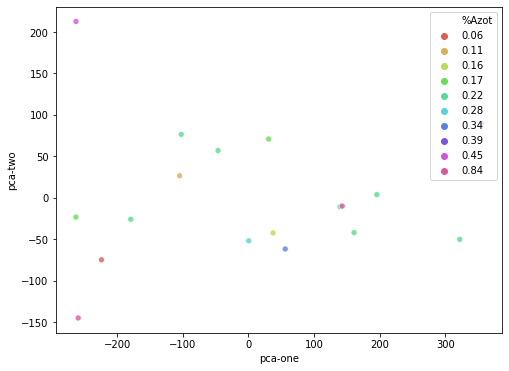

In [21]:
pca_df = analysis.apply_PCA(n_components=5)

[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Indexed 18 samples in 0.001s...
[t-SNE] Computed neighbors for 18 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 18 / 18
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.913513
[t-SNE] KL divergence after 300 iterations: 0.636235


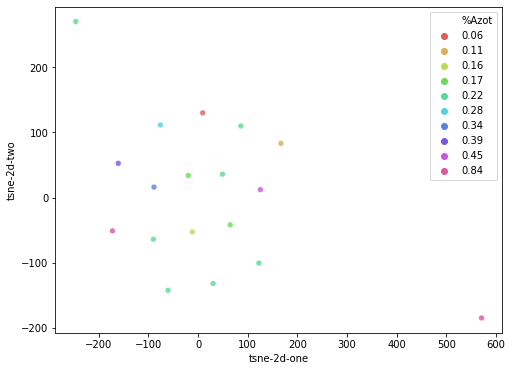

In [22]:
tsne_df = analysis.apply_tSNE(n_components=2)

In [27]:
analysis.plot()

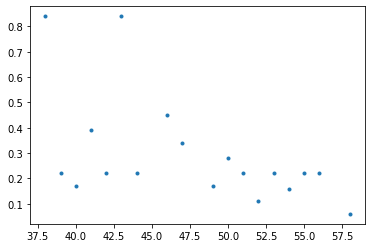

In [39]:
plt.plot(analysis.data['%Azot'], '.')

In [32]:
analysis.data

,Lab no,Loc,SampleNo,Valid,%Azot,N0@279.482,N1@334.762,N2@421.624,N3@443.506-N3@443.613,N4@498.2,N5@498.9,N6@499.9,N7@500.54,N8@501.6,N9@503.0,N10@589.024-N10@589.116
58,13070,Adana,45,1,0.06,200.787,85.743,46.654,199.424,174.714,215.036,400.967,550.083,295.202,190.979,387.292
52,13047,Adana,46,1,0.11,158.089,81.000,34.468,146.694,146.221,184.708,325.996,455.168,246.065,148.572,418.091
54,13053,Adana,29,1,0.16,155.394,83.254,25.274,109.383,122.773,157.980,295.787,393.234,213.270,130.568,286.421
40,12638,Adana,35,1,0.17,205.041,88.110,43.352,179.935,171.913,217.766,414.447,554.804,300.963,188.922,450.602
49,13039,Adana,32,1,0.17,155.150,80.127,26.045,151.334,121.706,148.891,264.297,347.454,192.615,127.908,389.858
39,12637,Adana,42,1,0.22,186.979,90.965,40.937,159.081,164.539,201.894,375.780,505.421,283.137,178.848,407.464
55,13061,Adana,47,1,0.22,134.330,81.221,31.775,99.787,105.801,130.024,243.395,319.215,173.391,109.343,226.917
42,12642,Adana,28,1,0.22,159.776,82.484,31.039,169.484,131.930,170.370,300.855,396.895,216.180,143.656,416.137
44,12645,Adana,30,1,0.22,136.206,78.864,22.262,185.258,109.358,133.939,232.848,308.965,174.294,108.533,267.190
53,13052,Adana,27,1,0.22,166.811,82.588,33.051,135.852,131.743,182.351,324.755,431.651,234.198,140.551,459.490
